In [ ]:
# Run this cell once in Colab
%pip install -q category_encoders pmdarima xgboost lightgbm catboost statsmodels joblib
print("Dependencies installed (or were already present).")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
Dependencies installed (or were already present).


In [ ]:
# --- FIX for pmdarima / numpy binary mismatch ---
!pip install -U numpy==1.26.4
!pip install --force-reinstall --no-cache-dir pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 103.9 MB/s eta 0:00:00
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
^C


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# optional boosters
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None

import category_encoders as ce

# time-series
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# persistence
import joblib

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Paths / outputs
OUTPUT_DIR = "/content/milestone2_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
PREPROCESSED_CSV = "/content/preprocessed_crop_data.csv"   # change if needed
RAW_CSV = "/content/crop_yield_dataset.csv"               # fallback raw csv


In [ ]:
# Load preprocessed if exists, else load raw
if os.path.exists(PREPROCESSED_CSV):
    print("Loading preprocessed CSV:", PREPROCESSED_CSV)
    df = pd.read_csv(PREPROCESSED_CSV)
else:
    print("Preprocessed not found. Loading raw CSV:", RAW_CSV)
    df = pd.read_csv(RAW_CSV)

print("Initial shape:", df.shape)
display(df.head(3))
print(df.columns.tolist())

# Basic checks
if 'Crop_Yield' not in df.columns:
    raise RuntimeError("Expected column 'Crop_Yield' missing. Fix CSV path or column name.")

Preprocessed not found. Loading raw CSV: /content/crop_yield_dataset.csv
Initial shape: (36520, 12)


,Date,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,2014-01-01,Wheat,Peaty,5.5,9.440599,80.000000,10.956707,60.5,45.0,31.5,0.00000,22.833333
1,2014-01-01,Corn,Loamy,6.5,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.87131,66.666667
2,2014-01-01,Rice,Peaty,5.5,12.143099,80.000000,7.227751,71.5,54.0,38.5,0.00000,27.333333


['Date', 'Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']


In [ ]:
# Drop rows where Crop_Yield == 0
before = len(df)
df = df[df['Crop_Yield'] != 0].reset_index(drop=True)
print(f"Dropped {before - len(df)} rows with zero yield. Remaining rows: {len(df)}")

# Quick dtypes and missing summary
print("\nDtypes:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Fill numeric NaNs with mean, categorical with "Unknown" (we'll refine per pipeline)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("\nNumeric cols (auto):", num_cols)
print("Categorical cols (auto):", cat_cols)

Dropped 11025 rows with zero yield. Remaining rows: 25495

Dtypes:
Date             object
Crop_Type        object
Soil_Type        object
Soil_pH         float64
Temperature     float64
Humidity        float64
Wind_Speed      float64
N               float64
P               float64
K               float64
Crop_Yield      float64
Soil_Quality    float64
dtype: object

Missing values per column:
Date            0
Crop_Type       0
Soil_Type       0
Soil_pH         0
Temperature     0
Humidity        0
Wind_Speed      0
N               0
P               0
K               0
Crop_Yield      0
Soil_Quality    0
dtype: int64

Numeric cols (auto): ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']
Categorical cols (auto): ['Date', 'Crop_Type', 'Soil_Type']


In [ ]:
expected_num = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']
expected_cat = [c for c in ['Crop_Type','Soil_Type'] if c in df.columns]

# Use expected if available, else infer numeric columns minus target
if set(expected_num).issubset(set(df.columns)):
    numerical_features = expected_num
else:
    numerical_features = [c for c in num_cols if c != 'Crop_Yield']

categorical_features = expected_cat

print("Numerical features used:", numerical_features)
print("Categorical features used:", categorical_features)

# Create ML DF (drop Date if present)
ml_df = df.copy()
if 'Date' in ml_df.columns:
    ml_df = ml_df.drop(columns=['Date'])
# Fill missing
ml_df[numerical_features] = ml_df[numerical_features].fillna(ml_df[numerical_features].mean())
for c in categorical_features:
    ml_df[c] = ml_df[c].fillna("Unknown")
print("ML DF shape:", ml_df.shape)
display(ml_df.head(2))

Numerical features used: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']
Categorical features used: ['Crop_Type', 'Soil_Type']
ML DF shape: (25495, 11)


,Crop_Type,Soil_Type,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
0,Corn,Loamy,6.50,20.052576,79.947424,8.591577,84.0,66.0,50.0,104.871310,66.666667
1,Barley,Sandy,6.75,19.751848,80.000000,2.682683,50.0,40.0,30.0,58.939796,35.000000


In [ ]:
X = ml_df.drop(columns=['Crop_Yield'])
y = ml_df['Crop_Yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (20396, 10) X_test: (5099, 10)


In [ ]:
from sklearn.model_selection import KFold

def evaluate_model(name, model, Xtr, Xte, ytr, yte, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(model, Xtr, ytr, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
        cv_rmse = np.mean(np.sqrt(-scores))
    except Exception:
        cv_rmse = np.nan
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)
    r2 = r2_score(yte, preds)
    mae = mean_absolute_error(yte, preds)
    rmse = np.sqrt(mean_squared_error(yte, preds))
    print(f"{name:30s} | CV_RMSE: {cv_rmse:8.4f} | Test RMSE: {rmse:8.4f} | MAE: {mae:8.4f} | R2: {r2:8.4f}")
    return {'name': name, 'cv_rmse': cv_rmse, 'test_rmse': rmse, 'mae': mae, 'r2': r2, 'preds': preds, 'model': model}

In [ ]:
# Pipeline A: OneHot + Standard + RF
preproc_A = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
], remainder='drop')

pipe_A = Pipeline([
    ('preproc', preproc_A),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

# Pipeline B: LeaveOneOut + MinMax + RF
preproc_B = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', ce.LeaveOneOutEncoder(cols=categorical_features, sigma=0.1), categorical_features)
], remainder='drop')

pipe_B = Pipeline([
    ('preproc', preproc_B),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

print("Pipelines defined.")


Pipelines defined.


In [ ]:
results = []
print("\nEvaluating Pipeline A (OneHot + Standard + RF):")
resA = evaluate_model("OneHot+Std+RF", pipe_A, X_train, X_test, y_train, y_test)
results.append(resA)

print("\nEvaluating Pipeline B (LOO + MinMax + RF):")
resB = evaluate_model("LOO+MinMax+RF", pipe_B, X_train, X_test, y_train, y_test)
results.append(resB)

comp_df = pd.DataFrame([{'pipeline': r['name'], 'cv_rmse': r['cv_rmse'], 'test_rmse': r['test_rmse'], 'mae': r['mae'], 'r2': r['r2']} for r in results])
display(comp_df)
comp_df.to_csv(os.path.join(OUTPUT_DIR, "pipeline_comparison_initial.csv"), index=False)


Evaluating Pipeline A (OneHot + Standard + RF):
OneHot+Std+RF                  | CV_RMSE:   4.8055 | Test RMSE:   4.8729 | MAE:   3.3602 | R2:   0.9530

Evaluating Pipeline B (LOO + MinMax + RF):
LOO+MinMax+RF                  | CV_RMSE:   4.6837 | Test RMSE:   4.7579 | MAE:   3.2908 | R2:   0.9552


,pipeline,cv_rmse,test_rmse,mae,r2
0,OneHot+Std+RF,4.805481,4.872868,3.360174,0.952999
1,LOO+MinMax+RF,4.683680,4.757930,3.290825,0.955190


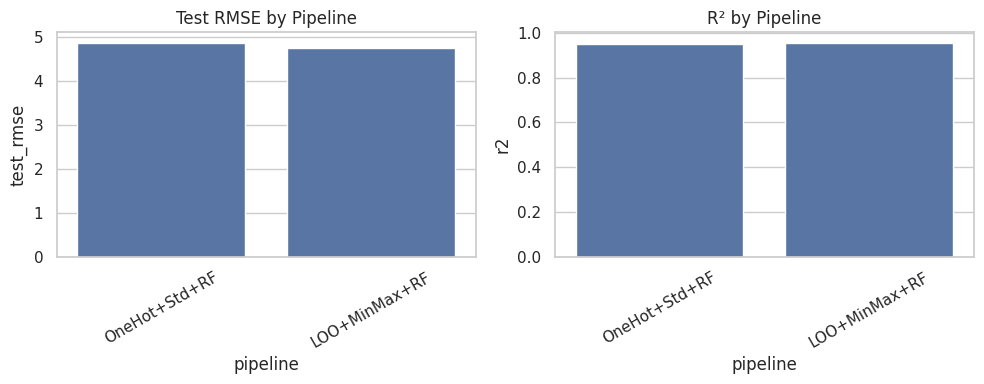

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.barplot(data=comp_df, x='pipeline', y='test_rmse')
plt.title('Test RMSE by Pipeline')
plt.xticks(rotation=30)

plt.subplot(1,2,2)
sns.barplot(data=comp_df, x='pipeline', y='r2')
plt.title('R² by Pipeline')
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
base_preproc = preproc_A
models_to_try = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
}
if XGBRegressor is not None:
    models_to_try["XGBoost"] = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)

ml_results = []
for name, estimator in models_to_try.items():
    pipeline = Pipeline([('preproc', base_preproc), ('model', estimator)])
    res = evaluate_model(name, pipeline, X_train, X_test, y_train, y_test)
    ml_results.append(res)

ml_df = pd.DataFrame([{'model': r['name'], 'cv_rmse': r['cv_rmse'], 'test_rmse': r['test_rmse'], 'mae': r['mae'], 'r2': r['r2']} for r in ml_results]).sort_values('test_rmse')
display(ml_df)
ml_df.to_csv(os.path.join(OUTPUT_DIR, "ml_model_comparison.csv"), index=False)

LinearRegression               | CV_RMSE:  14.7683 | Test RMSE:  14.6599 | MAE:  11.1899 | R2:   0.5746
Ridge                          | CV_RMSE:  14.7680 | Test RMSE:  14.6589 | MAE:  11.1887 | R2:   0.5747
Lasso                          | CV_RMSE:  14.7704 | Test RMSE:  14.6464 | MAE:  11.1793 | R2:   0.5754
DecisionTree                   | CV_RMSE:   6.3824 | Test RMSE:   6.3129 | MAE:   4.3748 | R2:   0.9211
RandomForest                   | CV_RMSE:   4.8055 | Test RMSE:   4.8729 | MAE:   3.3602 | R2:   0.9530
XGBoost                        | CV_RMSE:   4.8863 | Test RMSE:   4.8897 | MAE:   3.4485 | R2:   0.9527


,model,cv_rmse,test_rmse,mae,r2
4,RandomForest,4.805481,4.872868,3.360174,0.952999
5,XGBoost,4.886349,4.889666,3.448472,0.952675
3,DecisionTree,6.382356,6.312949,4.374778,0.921114
2,Lasso,14.770420,14.646429,11.179293,0.575381
1,Ridge,14.767980,14.658919,11.188735,0.574657
0,LinearRegression,14.768275,14.659946,11.189904,0.574597


In [ ]:
# pick best by smallest test_rmse
best_row = ml_df.iloc[0]
best_name = best_row['model']
print("Best model by test RMSE:", best_name)

best_estimator = models_to_try[best_name]
best_pipeline = Pipeline([('preproc', base_preproc), ('model', best_estimator)])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

metrics = {'r2': r2_score(y_test, y_pred),
           'mae': mean_absolute_error(y_test, y_pred),
           'rmse': np.sqrt(mean_squared_error(y_test, y_pred))}
print("Test metrics (best):", metrics)

# Save predictions
pred_df = X_test.copy()
pred_df['y_true'] = y_test.values
pred_df['y_pred'] = y_pred
pred_path = os.path.join(OUTPUT_DIR, "best_pipeline_predictions.csv")
pred_df.to_csv(pred_path, index=False)
print("Saved predictions to:", pred_path)

# Save the best pipeline
pipeline_path = os.path.join(OUTPUT_DIR, f"best_pipeline_{best_name.replace(' ','_')}.joblib")
joblib.dump(best_pipeline, pipeline_path)
print("Saved best pipeline to:", pipeline_path)

Best model by test RMSE: RandomForest
Test metrics (best): {'r2': 0.9529992486509489, 'mae': 3.360173635100181, 'rmse': 4.8728675919187365}
Saved predictions to: /content/milestone2_outputs/best_pipeline_predictions.csv
Saved best pipeline to: /content/milestone2_outputs/best_pipeline_RandomForest.joblib


Saved daily timeseries to: /content/milestone2_outputs/preprocessed_timeseries.csv


,Soil_pH,Temperature,Humidity,Wind_Speed,N,P,K,Crop_Yield,Soil_Quality
Date,,,,,,,,,
2014-01-01,6.250000,17.832341,79.992489,7.649061,61.285714,50.142857,40.142857,52.962570,41.714286
2014-01-02,6.928571,17.403738,79.997477,9.731096,67.285714,54.500000,43.785714,49.481053,31.964286
2014-01-03,6.250000,17.710699,78.611669,12.161914,60.785714,49.571429,40.142857,31.582386,40.601190
2014-01-04,7.125000,17.068594,79.349411,9.476664,69.375000,56.000000,44.937500,35.247034,38.703125
2014-01-05,6.375000,15.439732,80.000000,10.793227,68.062500,54.562500,43.125000,32.578187,48.994792


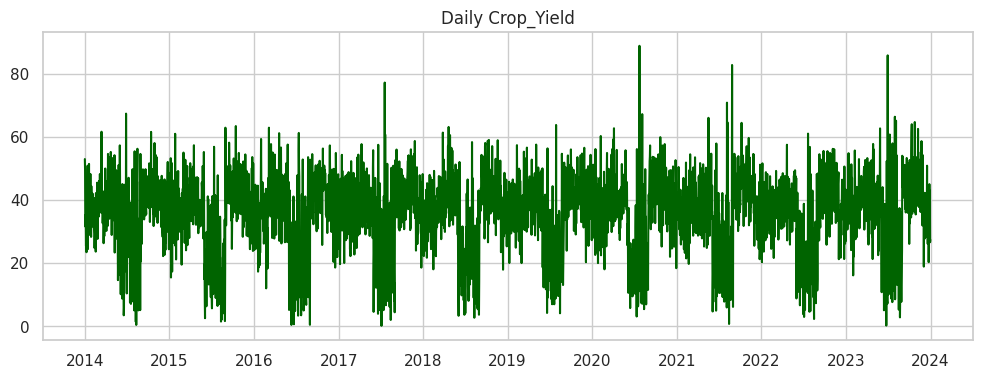


Augmented Dickey-Fuller test:
ADF stat: -7.148107107405443 p-value: 3.19331085413878e-10
1% -3.4321632328202996
5% -2.862341184885642
10% -2.567196483328331
=> stationary if p < 0.05

KPSS test:
KPSS stat: 0.043423677627070334 p-value: 0.1
10% 0.347
5% 0.463
2.5% 0.574
1% 0.739
=> KPSS stationary if p > 0.05


/tmp/ipython-input-903245805.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_res = kpss(series, regression='c', nlags='auto')


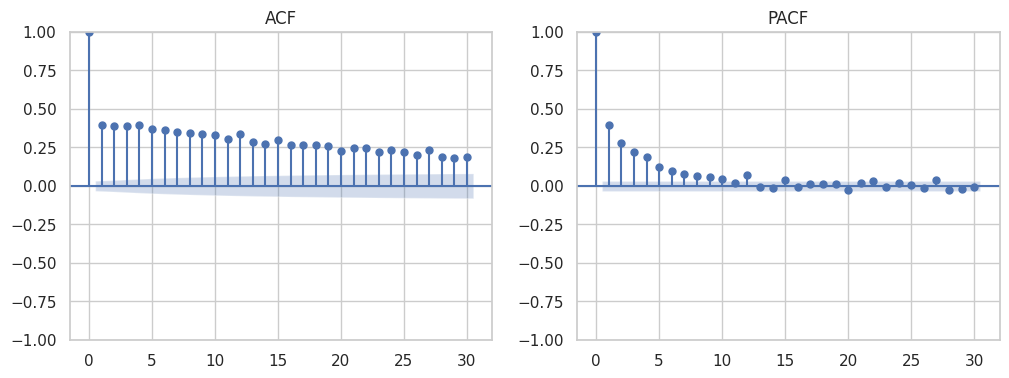

In [ ]:
if 'Date' in df.columns:
    ts = df.copy()
    ts['Date'] = pd.to_datetime(ts['Date'], errors='coerce')
    ts = ts.dropna(subset=['Date']).set_index('Date')
    ts_daily = ts.resample('D').mean(numeric_only=True)
    ts_daily.to_csv(os.path.join(OUTPUT_DIR, "preprocessed_timeseries.csv"))
    print("Saved daily timeseries to:", os.path.join(OUTPUT_DIR, "preprocessed_timeseries.csv"))
    display(ts_daily.head())

    # Choose series
    series = ts_daily['Crop_Yield'].dropna()
    plt.figure(figsize=(12,4))
    plt.plot(series, color='darkgreen')
    plt.title('Daily Crop_Yield')
    plt.show()

    # ADF
    print("\nAugmented Dickey-Fuller test:")
    adf_res = adfuller(series)
    print("ADF stat:", adf_res[0], "p-value:", adf_res[1])
    for k,v in adf_res[4].items():
        print(k, v)
    print("=> stationary if p < 0.05")

    # KPSS
    print("\nKPSS test:")
    try:
        kpss_res = kpss(series, regression='c', nlags='auto')
        print("KPSS stat:", kpss_res[0], "p-value:", kpss_res[1])
        for k,v in kpss_res[3].items():
            print(k, v)
    except Exception as e:
        print("KPSS test error:", e)
    print("=> KPSS stationary if p > 0.05")

    # ACF / PACF
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    plot_acf(series, lags=30, ax=axes[0])
    plot_pacf(series, lags=30, ax=axes[1])
    axes[0].set_title('ACF')
    axes[1].set_title('PACF')
    plt.show()
else:
    print("Date column not present — skipping time-series steps.")

Fitting ARIMA(1,0,1)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Crop_Yield   No. Observations:                 3624
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -13497.510
Date:                Sun, 02 Nov 2025   AIC                          27003.020
Time:                        11:44:17   BIC                          27027.801
Sample:                             0   HQIC                         27011.848
                               - 3624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.7733      1.270     28.164      0.000      33.284      38.263
ar.L1          0.9752      0.004    226.470      0.000       0.967       0.984
ma.L1         -0.8275      0.010    -80.564      0.0

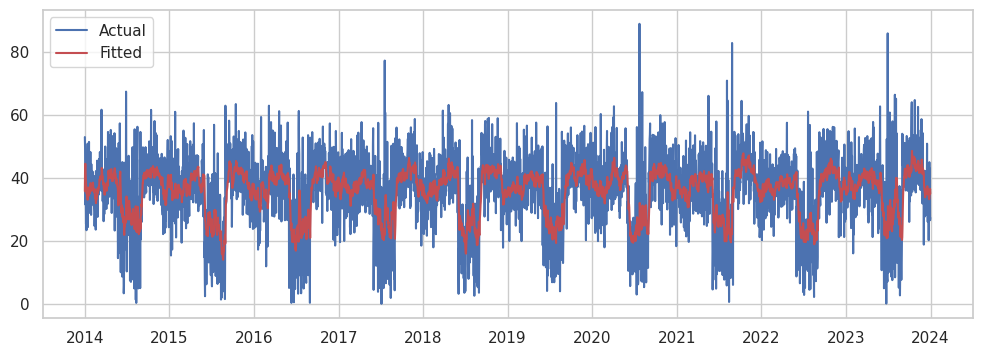

Running auto_arima (may take time)...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3624
Model:               SARIMAX(1, 0, 3)   Log Likelihood              -13495.148
Date:                Sun, 02 Nov 2025   AIC                          27002.296
Time:                        11:45:27   BIC                          27039.468
Sample:                             0   HQIC                         27015.539
                               - 3624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9974      0.163      6.135      0.000       0.679       1.316
ar.L1          0.9721      0.005    202.673      0.000       0.963       0.982
ma.L1         

In [ ]:
if 'Date' in df.columns:
    try:
        print("Fitting ARIMA(1,0,1)...")
        arima_model = ARIMA(series, order=(1,0,1))
        arima_fit = arima_model.fit()
        print(arima_fit.summary())
        plt.figure(figsize=(12,4))
        plt.plot(series, label='Actual')
        plt.plot(arima_fit.fittedvalues, color='r', label='Fitted')
        plt.legend()
        plt.show()
    except Exception as e:
        print("ARIMA failed:", e)

    # auto_arima (can be slow)
    try:
        print("Running auto_arima (may take time)...")
        auto_res = auto_arima(series, seasonal=False, trace=False, error_action='ignore', suppress_warnings=True, max_p=5, max_q=5)
        print(auto_res.summary())
    except Exception as e:
        print("auto_arima failed or took long:", e)

In [ ]:
# Already saved earlier; list output folder
print("Files in", OUTPUT_DIR)
print(os.listdir(OUTPUT_DIR))

# Save ml_df and comp_df if present
if 'ml_df' in globals():
    ml_df.to_csv(os.path.join(OUTPUT_DIR, "ml_model_comparison_sorted.csv"), index=False)
print("Saved model comparisons.")

Files in /content/milestone2_outputs
['best_pipeline_predictions.csv', 'best_pipeline_RandomForest.joblib', 'ml_model_comparison.csv', 'pipeline_comparison_initial.csv', 'preprocessed_timeseries.csv']
Saved model comparisons.


In [ ]:
# --- CONFIGURE THESE ---
GIT_REPO_URL = "https://github.com/springboardmentor789r/AgriYield.git"
BRANCH_NAME = "intern-ArupKanungo"
NOTEBOOK_FILENAME = "milestone2_agri_yield.ipynb"  # ensure your Colab notebook is named this before running

# 1) Ask for PAT securely
from getpass import getpass
token = getpass("Enter your GitHub Personal Access Token (will not echo): ")

# 2) Clone the repo (or pull if exists) into /content/repo
REPO_DIR = "/content/AgriYield"
if os.path.exists(REPO_DIR):
    print("Repo directory exists — pulling latest changes.")
    %cd {REPO_DIR}
    !git pull
    %cd /content
else:
    # clone with token in URL (private repo access)
    clone_url = GIT_REPO_URL.replace("https://", f"https://{token}@")
    print("Cloning:", GIT_REPO_URL)
    !git clone {clone_url} {REPO_DIR}
    # remove token from history (just in case)
    %cd /content

# 3) Create branch and switch to it
%cd {REPO_DIR}
!git checkout -b {BRANCH_NAME}

# 4) Copy this notebook file into the repo folder
import shutil
src_nb_path = f"/content/{NOTEBOOK_FILENAME}"
dest_nb_path = f"{REPO_DIR}/{NOTEBOOK_FILENAME}"
if os.path.exists(src_nb_path):
    shutil.copy(src_nb_path, dest_nb_path)
    print("Copied notebook to repo:", dest_nb_path)
else:
    print("Notebook file not found at", src_nb_path)
    print("Make sure your notebook is saved with name:", NOTEBOOK_FILENAME)

# 5) Stage, commit, push
!git add -A
!git commit -m "Milestone 2: pipelines + timeseries - Arup Kanungo" || true
push_url = GIT_REPO_URL.replace("https://", f"https://{token}@")
!git push {push_url} {BRANCH_NAME}

print("Done. If push succeeded, visit the repo to create a Pull Request.")

Enter your GitHub Personal Access Token (will not echo): ··········
Cloning: https://github.com/springboardmentor789r/AgriYield.git
Cloning into '/content/AgriYield'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 122 (delta 13), reused 2 (delta 2), pack-reused 78 (from 2)
Receiving objects: 100% (122/122), 37.14 MiB | 25.32 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content
/content/AgriYield
Switched to a new branch 'intern-ArupKanungo'
Notebook file not found at /content/milestone2_agri_yield.ipynb
Make sure your notebook is saved with name: milestone2_agri_yield.ipynb
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got '

In [1]:
!cp "/content/drive/MyDrive/Colab Notebooks/milestone2_agri_yield.ipynb" /content/


cp: cannot stat '/content/drive/MyDrive/Colab Notebooks/milestone2_agri_yield.ipynb': No such file or directory


In [2]:
!ls "/content/drive/MyDrive/Colab Notebooks"


ls: cannot access '/content/drive/MyDrive/Colab Notebooks': No such file or directory


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/Colab Notebooks"


 AgriYield2.ipynb  'milestone2_agri_yield (1).ipynb.ipynb'   Untitled0.ipynb
 Agriyield.ipynb    milestone2_agri_yield.ipynb.ipynb	     Untitled1.ipynb


In [3]:
!mv "/content/drive/MyDrive/Colab Notebooks/milestone2_agri_yield.ipynb.ipynb" "/content/drive/MyDrive/Colab Notebooks/milestone2_agri_yield.ipynb"


In [5]:
!ls "/content/drive/MyDrive"


'1712745962192 (1).jpg'
'1712745962192 (2).jpg'
'1712745962192 (3).jpg'
 1712745962192.jpg
'2301292431_ARUPANANDA KANUNGO_HUMAN AI.pdf'
'Adobe Scan 13-Dec-2023 (1).pdf'
 arup_testimonial.mp4
'Assgn que module-II-1.gdoc'
'assignment 3 civil .pdf'
'BCE ASSIGNMENT-2.pdf'
 Classroom
'Colab Notebooks'
 CV_2024-04-10-040947.pdf
'diabetes (1).gsheet'
 diabetes.gsheet
'DocScanner 10-Nov-2023 10-14 pm (1).pdf'
'DocScanner 10-Nov-2023 10-14 pm.pdf'
'DocScanner 13-Dec-2023 8-22 pm.pdf'
'eng Assignment 1-1(22903355050156).jpg'
'eng Assignment 1.pdf'
'fotor-ai-202410019163 (1).jpg'
 fotor-ai-202410019163.jpg
'getting started with Ai.png'
 Help-for-Poor-People-and-Animals.pdf
 IBMDesign20250716-27-6dusbp.pdf
 IBMDesign20250719-25-yhvqe5.pdf
'ibm project (1).pdf'
'ibm project.pdf'
'IMG-20230628-WA0004 (1).jpg'
'IMG-20230628-WA0004 (2).jpg'
 IMG-20230628-WA0004.jpg
 IMG-20240410-WA0007.jpg
 IMG-20240430-WA0000.jpg
'IMG-20250612-WA0001 (1).jpg'
 IMG-20250612-WA0001.jpg
'internpe offer letter  (1).pdf'


In [6]:
!ls "/content/drive/MyDrive/Colab Notebooks"


 AgriYield2.ipynb  'milestone2_agri_yield (1).ipynb.ipynb'   Untitled0.ipynb
 Agriyield.ipynb    milestone2_agri_yield.ipynb.ipynb	     Untitled1.ipynb


In [ ]:
# --- CONFIGURE THESE ---
GIT_REPO_URL = "https://github.com/springboardmentor789r/AgriYield.git"
BRANCH_NAME = "intern-ArupKanungo"   # your unique branch name
NOTEBOOK_FILENAME = "milestone2_agri_yield.ipynb"  # <-- make sure your notebook is saved with this name in /content

# 1) Ask for your Personal Access Token (PAT)
from getpass import getpass
import os, shutil

token = getpass("Enter your GitHub Personal Access Token (will not echo): ")

# 2) Clone the mentor's repository or pull latest
REPO_DIR = "/content/AgriYield"

if os.path.exists(REPO_DIR):
    print("Repo directory exists — pulling latest changes.")
    %cd {REPO_DIR}
    !git pull
    %cd /content
else:
    clone_url = GIT_REPO_URL.replace("https://", f"https://{token}@")
    print("Cloning:", GIT_REPO_URL)
    !git clone {clone_url} {REPO_DIR}
    %cd /content

# 3) Create and switch to your branch
%cd {REPO_DIR}
!git checkout -b {BRANCH_NAME}

# 4) Copy the notebook into the repo
src_nb_path = f"/content/{NOTEBOOK_FILENAME}"
dest_nb_path = f"{REPO_DIR}/{NOTEBOOK_FILENAME}"

if os.path.exists(src_nb_path):
    shutil.copy(src_nb_path, dest_nb_path)
    print("✅ Copied notebook to repo:", dest_nb_path)
else:
    print("❌ Notebook not found at", src_nb_path)
    print("Make sure your notebook is saved as:", NOTEBOOK_FILENAME)

# 5) Stage, commit, and push
!git add -A
!git commit -m "Milestone 2: pipelines + time series analysis - Arup Kanungo" || true
push_url = GIT_REPO_URL.replace("https://", f"https://{token}@")
!git push {push_url} {BRANCH_NAME}

print("\n🎯 Done! If no errors, go to your repo branch and create a Pull Request.")
